In [1]:
generating_class = 'PASSENGERSSHIP'
real_dir = 'DATASET54000'
fake_dir = 'DCGAN-F64'
fake_dirx4 = 'DCGAN-F64x4'

In [2]:
from keras import layers
from keras import ops
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os
import keras
import tensorflow as tf

import torch
import torchvision
import cv2

from realesrgan import RealESRGANer
from basicsr.archs.rrdbnet_arch import RRDBNet
from PIL import Image
import numpy as np
import requests

from skimage.metrics import structural_similarity as ssim
from torchvision import transforms
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from itertools import product


print(f"Versão do Tensorflow: {tf.__version__}")
devices = tf.config.list_physical_devices('GPU')
if devices:
    print(f"GPU disponivel: {devices}")
    print(f"Número de GPUs: {len(devices)}")
else:
    print("GPU não está disponível. Usando CPU")

print(f"PyTorch version: {torch.__version__}")
print(torchvision.__version__)
print(torch.cuda.is_available())  # Deve retornar True se a GPU estiver configurada corretamente
print(torch.cuda.get_device_name(0))  # Nome da GPU

2025-04-22 20:25:53.554176: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 20:25:53.575648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Versão do Tensorflow: 2.16.1
GPU disponivel: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Número de GPUs: 1
PyTorch version: 2.0.1+cu118
0.15.2+cu118
True
NVIDIA GeForce RTX 4090


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
2025-04-22 20:25:55.350945: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-22 20:25:55.354542: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-22 20:25:55.354560: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/

Found 5400 files.


2025-04-22 20:26:02.646704: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-22 20:26:02.646740: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-22 20:26:02.646749: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-22 20:26:02.771881: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-22 20:26:02.771909: I external/local_xla/xla/stream_executor

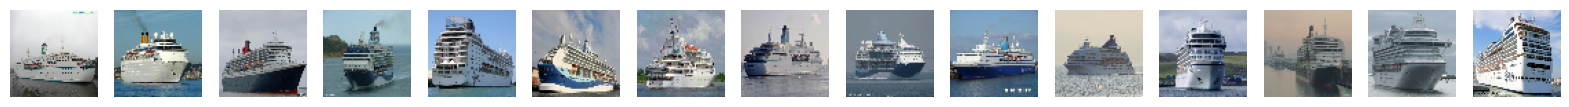

In [3]:
input_dir = str(real_dir + '/' + generating_class)

dataset = keras.utils.image_dataset_from_directory(
    input_dir, label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

for x in dataset:
    plt.figure(figsize=(20,15))

    for i in range (15):
        plt.subplot(1, 15, i + 1)
        plt.axis("off")
        plt.imshow((x.numpy() * 255).astype("int32")[i])
    break

In [4]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, d_steps):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = d_steps
        self.seed_generator = keras.random.SeedGenerator(1337)
        

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        total_d_loss = 0.0

        for _ in range(self.d_steps):
            random_latent_vectors = keras.random.normal(
                shape=(batch_size, self.latent_dim), seed=self.seed_generator
            )
    
            # Decode them to fake images
            generated_images = self.generator(random_latent_vectors)
    
            # Combine them with real images
            combined_images = ops.concatenate([generated_images, real_images], axis=0)
    
            # Assemble labels discriminating real from fake images
            labels = ops.concatenate(
                [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
            )
            # Add random noise to the labels - important trick!
            labels += 0.05 * tf.random.uniform(tf.shape(labels))
    
            # Train the discriminator
            with tf.GradientTape() as tape:
                predictions = self.discriminator(combined_images)
                d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            total_d_loss += d_loss

        avg_d_loss = total_d_loss/self.d_steps
        
        # Update metrics
        self.d_loss_metric.update_state(avg_d_loss)

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))
        
        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.g_loss_metric.update_state(g_loss)
            
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [7]:
# Diretório onde os modelos serão salvos
checkpoint_dir = str("DCGAN-MODELS/" + generating_class)
os.makedirs(checkpoint_dir, exist_ok=True)

# Caminho do modelo salvo
checkpoint_path = os.path.join(checkpoint_dir, "dcgan_checkpoint.keras")
best_path = os.path.join(checkpoint_dir, "best_dcgan_checkpoint.keras")

# Verifica se há um modelo salvo para continuar o treinamento
if os.path.exists(checkpoint_path):
    print("Carregando modelo salvo para continuar o treinamento...")
    generator = keras.models.load_model(checkpoint_path)
    discriminator = keras.models.load_model(checkpoint_path.replace("dcgan_checkpoint", "dcgan_discriminator"))
else:
    print("Nenhum modelo salvo encontrado. Treinando do zero...")

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=15, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)
        self.best_fid = 999

    def on_epoch_end(self, epoch, logs=None):      
        calc_dir = str('DCGAN-RESULTS' + "/" + generating_class)
        os.makedirs(calc_dir, exist_ok=True)
        calc_filename = str(generating_class + "%d.png")
        calc_path = os.path.join(calc_dir, calc_filename)

        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = gan.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(calc_path % (i))

        real_class_dir = os.path.join(real_dir, generating_class)
        generated_class_dir = os.path.join('DCGAN-RESULTS', generating_class)
        
        real_files = [os.path.join(real_class_dir, f) for f in os.listdir(real_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
        gen_files = [os.path.join(generated_class_dir, f) for f in os.listdir(generated_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
        
        fid = FrechetInceptionDistance()
        
        for real_file, gen_file in zip(real_files, gen_files):
            real_batch = load_image(real_file)
            gen_batch = load_image(gen_file)
            fid.update(real_batch, real=True)
            fid.update(gen_batch, real=False)

        fid_score = fid.compute()
        print(f'   - FID: {fid_score.item()} .')

        save_fid[epoch] = fid_score.item()
        
        if fid_score.item() < self.best_fid:
            self.best_fid = fid_score.item()
            print(f"Melhor FID encontardo: {self.best_fid}, salvando gerador...")
            generator.save(best_path)
            discriminator.save(best_path.replace("best_dcgan_checkpoint", "best_dcgan_discriminator"))

        if (epoch + 1) % 100 == 0:
            plt.figure(figsize=(20, 15))
            for i in range (20):
                plt.subplot(1, 20, i + 1)
                plt.axis("off")
                amostra = keras.utils.array_to_img(generated_images[i])
                plt.imshow(amostra)
            plt.show()
            generator.save(checkpoint_path)
            discriminator.save(checkpoint_path.replace("dcgan_checkpoint", "dcgan_discriminator"))
            print(f"Modelo salvo após {epoch + 1} épocas.")

Nenhum modelo salvo encontrado. Treinando do zero...


In [8]:
### AUMENTO DE IMAGENS ###



weights_path = "RealESRGAN_x4plus.pth"

# Função para baixar os pesos se não existirem
def download_weights():
    if not os.path.exists(weights_path):
        print("Pesos do modelo não encontrados. Fazendo download...")
        url = "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth"
        response = requests.get(url, stream=True)
        with open(weights_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print("Download concluído!")

# Baixar os pesos, se necessário
download_weights()

def process_images(input_dir, output_dir):
    # Certifique-se de que o diretório de saída existe
    os.makedirs(output_dir, exist_ok=True)

    # Inicialize o modelo Real-ESRGAN
    model = RRDBNet(
        num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4
    )
    upscaler = RealESRGANer(
        scale=4,  # Fator de escala
        model_path=weights_path,  # Caminho dos pesos do modelo
        model=model,  # Modelo definido acima
        tile=0,  # Defina um tamanho de tile se tiver limitações de memória
        tile_pad=10,  # Padding ao redor dos tiles
        pre_pad=0,  # Preenchimento adicional antes do processamento
        half=True,  # Utilize FP16 para economizar memória em GPUs compatíveis
    )

    # Iterar sobre todas as imagens no diretório de entrada
    for filename in tqdm(os.listdir(input_dir),desc="Aumentando imagens"):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Abra a imagem de entrada
                with Image.open(input_path) as img:
                    # Converta a imagem para array NumPy
                    input_image = np.array(img)

                    # Aplique a super-resolução
                    sr_image, _ = upscaler.enhance(input_image, outscale=4)

                    # Salve a imagem processada
                    Image.fromarray(sr_image).save(output_path)
                    #print(f"Processado: {filename} -> {output_path}")
            except Exception as e:
                print(f"Erro ao processar {filename}: {e}")

In [9]:
### CÁLCULO DE MÉTRICAS ###



# Configurações globais
image_size = 64  # Dimensão para redimensionar imagens
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Função para carregar e pré-processar uma imagem
def load_image(image_path):
    with Image.open(image_path) as img:
        img = img.convert("RGB")
        tensor = transform(img) * 255  # Escalar de [0, 1] para [0, 255]
        return tensor.to(torch.uint8).unsqueeze(0)  # Adiciona dimensão de batch (1, C, H, W)

# Função para calcular SSIM
def calculate_ssim(img1, img2):
    img1 = np.array(img1)
    img2 = np.array(img2)
    return ssim(img1, img2, channel_axis=-1)

# Função principal para calcular métricas para uma classe específica
def calculate_metrics(real_dir, generated_dir, target_class, num_samples=100, batch_size=10):
    real_class_dir = os.path.join(real_dir, target_class)
    generated_class_dir = os.path.join(generated_dir, target_class)

    # Listar imagens nas pastas
    real_files = [os.path.join(real_class_dir, f) for f in os.listdir(real_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
    gen_files = [os.path.join(generated_class_dir, f) for f in os.listdir(generated_class_dir) if f.endswith(("png", "jpg", "jpeg"))]

    if len(real_files) < num_samples or len(gen_files) < num_samples:
        raise ValueError(f"Imagens insuficientes para a classe '{target_class}'. É necessário pelo menos {num_samples} imagens por classe.")

    sampled_real = np.random.choice(real_files, num_samples, replace=False)
    sampled_gen = np.random.choice(gen_files, num_samples, replace=False)

    ssim_scores = []
    fid = FrechetInceptionDistance()
    inception_score_real = InceptionScore()
    inception_score_gen = InceptionScore()

    # Usar tqdm para mostrar o progresso
    for i in tqdm(range(0, num_samples, batch_size), desc=f"Processando classe '{target_class}'"):
        batch_real_files = sampled_real[i:i + batch_size]
        batch_gen_files = sampled_gen[i:i + batch_size]

        real_batch = []
        gen_batch = []

        for real_file, gen_file in zip(batch_real_files, batch_gen_files):
            with Image.open(real_file) as real_img, Image.open(gen_file) as gen_img:
                real_img = real_img.convert("RGB").resize((image_size, image_size))
                gen_img = gen_img.convert("RGB").resize((image_size, image_size))

                # Calcular SSIM
                ssim_scores.append(calculate_ssim(real_img, gen_img))

                # Preparar imagens para FID e Inception
                real_batch.append(load_image(real_file))
                gen_batch.append(load_image(gen_file))

        # Concatenar batches
        real_batch = torch.cat(real_batch, dim=0)
        gen_batch = torch.cat(gen_batch, dim=0)

        # Atualizar Inception Score e FID por batch
        inception_score_real.update(real_batch)
        inception_score_gen.update(gen_batch)
        fid.update(real_batch, real=True)
        fid.update(gen_batch, real=False)

    # Calcular métricas finais
    is_real, _ = inception_score_real.compute()
    is_gen, _ = inception_score_gen.compute()
    fid_score = fid.compute()

    # Salvar métricas
    metrics = {
        "SSIM (média)": np.mean(ssim_scores),
        "Inception Score (Real)": is_real.item(),
        "Inception Score (Gerado)": is_gen.item(),
        "FID": fid_score.item()
    }

    return metrics

# Função para exibir as métricas
def print_metrics(metrics, target_class):
    print(f"\nMétricas para a classe '{target_class}':")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# Função para plotar resumo das métricas para a classe
def plot_metrics_for_class(metrics, target_class):
    labels = ["SSIM (média)", "FID", "Inception Score (Real)", "Inception Score (Gerado)"]
    values = [metrics["SSIM (média)"], metrics["FID"], metrics["Inception Score (Real)"], metrics["Inception Score (Gerado)"]]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, values, color=['blue', 'orange', 'green', 'red'])
    plt.title(f"Métricas para a classe '{target_class}'")
    plt.ylabel("Valores")
    plt.tight_layout()

    # Adicionar os valores nas barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha='center', va='bottom')

    # Salvar o gráfico
    plt.savefig(f"DCGAN-RESULTS/DCGAN-METRICS-{target_class}.png")
    plt.show()

Epoch 1/1500


I0000 00:00:1745353572.773937   58836 service.cc:145] XLA service 0x7fbd20005270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745353572.773988   58836 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-22 20:26:12.833601: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1745353572.898894   58836 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
2025-04-22 20:26:13.122513: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1745353581.693679   58836 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - d_loss: 0.3179 - g_loss: 3.9337

2025-04-22 20:26:37.682181: W tensorflow/core/kernels/gpu_utils.cc:68] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


   - FID: 360.5356140136719 .
Melhor FID encontardo: 360.5356140136719, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 76s 392ms/step - d_loss: 0.3178 - g_loss: 3.9396
Epoch 2/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - d_loss: 0.1520 - g_loss: 7.7802   - FID: 319.5751953125 .
Melhor FID encontardo: 319.5751953125, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 323ms/step - d_loss: 0.1522 - g_loss: 7.7644
Epoch 3/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - d_loss: 0.1826 - g_loss: 2.9781   - FID: 308.5872497558594 .
Melhor FID encontardo: 308.5872497558594, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 316ms/step - d_loss: 0.1827 - g_loss: 2.9788
Epoch 4/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - d_loss: 0.1806 - g_loss: 4.3379   - FID: 330.2037353515625 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 320ms/step - d_loss: 0.1808 - g_loss: 4.3365
Epoch 5/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - d_loss: 0.1755 - g_loss: 4.1932   - FID: 333.81402587890625 .
169/1

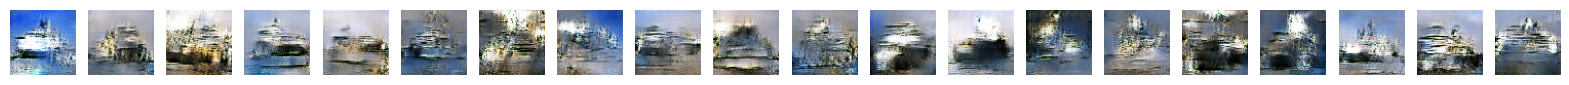

Modelo salvo após 100 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.3289 - g_loss: 2.5535
Epoch 101/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3376 - g_loss: 2.5069   - FID: 166.01104736328125 .
Melhor FID encontardo: 166.01104736328125, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.3376 - g_loss: 2.5066
Epoch 102/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.3555 - g_loss: 2.3657   - FID: 154.8905792236328 .
Melhor FID encontardo: 154.8905792236328, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 304ms/step - d_loss: 0.3554 - g_loss: 2.3659
Epoch 103/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3603 - g_loss: 2.4023   - FID: 182.87094116210938 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - d_loss: 0.3602 - g_loss: 2.4030
Epoch 104/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3312 - g_loss: 2.8180   - FID: 194.03846740722656 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 304ms/step - d_lo

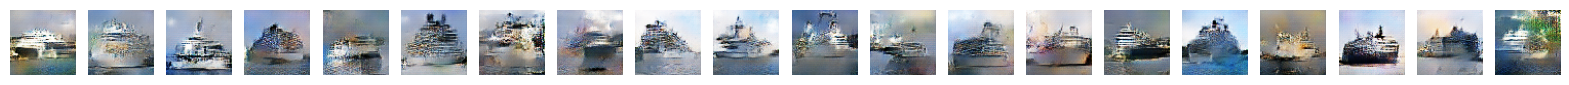

Modelo salvo após 200 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.3256 - g_loss: 2.4046
Epoch 201/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - d_loss: 0.3363 - g_loss: 2.3891   - FID: 111.44367980957031 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.3363 - g_loss: 2.3890
Epoch 202/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.3537 - g_loss: 2.4339   - FID: 110.49797058105469 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.3536 - g_loss: 2.4334
Epoch 203/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3379 - g_loss: 2.6041   - FID: 92.85259246826172 .
Melhor FID encontardo: 92.85259246826172, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.3379 - g_loss: 2.6038
Epoch 204/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3335 - g_loss: 2.4710   - FID: 91.99918365478516 .
Melhor FID encontardo: 91.99918365478516, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss

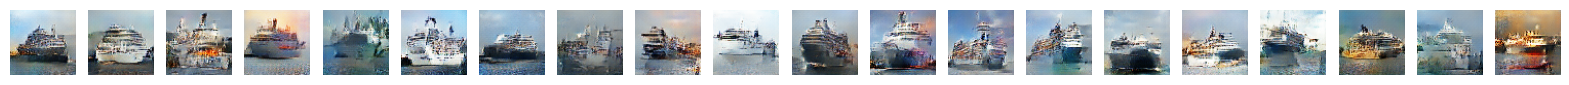

Modelo salvo após 300 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 325ms/step - d_loss: 0.2836 - g_loss: 2.9047
Epoch 301/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3180 - g_loss: 2.5842   - FID: 79.20255279541016 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: 0.3180 - g_loss: 2.5840
Epoch 302/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3094 - g_loss: 2.4992   - FID: 77.04702758789062 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.3094 - g_loss: 2.4997
Epoch 303/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - d_loss: 0.3224 - g_loss: 2.6329   - FID: 79.57998657226562 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.3223 - g_loss: 2.6331
Epoch 304/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3196 - g_loss: 2.7756   - FID: 77.63724517822266 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 311ms/step - d_loss: 0.3196 - g_loss: 2.7760
Epoch 305/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3039 - g_loss: 2.6290   - FID: 

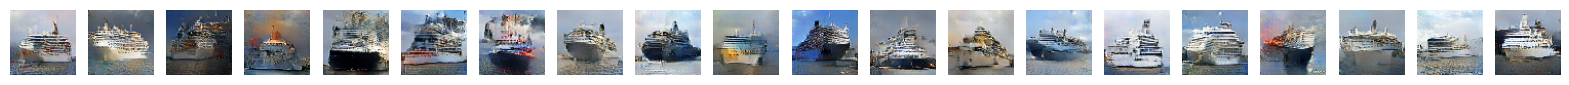

Modelo salvo após 400 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 322ms/step - d_loss: 0.2658 - g_loss: 3.0541
Epoch 401/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2590 - g_loss: 3.0765   - FID: 68.63241577148438 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 316ms/step - d_loss: 0.2590 - g_loss: 3.0768
Epoch 402/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2775 - g_loss: 3.0678   - FID: 74.66960144042969 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.2774 - g_loss: 3.0675
Epoch 403/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2757 - g_loss: 3.0434   - FID: 69.44090270996094 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - d_loss: 0.2756 - g_loss: 3.0429
Epoch 404/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.2755 - g_loss: 2.9318   - FID: 70.29244995117188 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: 0.2754 - g_loss: 2.9320
Epoch 405/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.2776 - g_loss: 2.8942   - FID: 

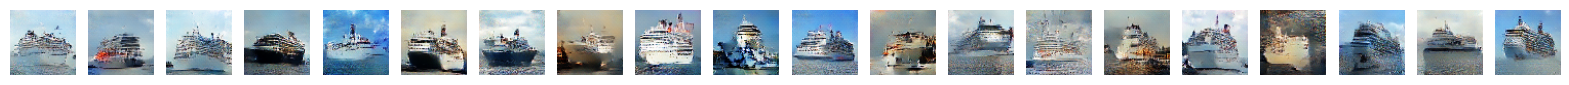

Modelo salvo após 500 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 316ms/step - d_loss: 0.2139 - g_loss: 3.6441
Epoch 501/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2014 - g_loss: 3.8019   - FID: 64.82412719726562 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.2015 - g_loss: 3.8005
Epoch 502/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2009 - g_loss: 3.6585   - FID: 68.79341125488281 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.2010 - g_loss: 3.6579
Epoch 503/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.2104 - g_loss: 3.5787   - FID: 64.51598358154297 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.2104 - g_loss: 3.5790
Epoch 504/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2090 - g_loss: 3.8267   - FID: 62.60636901855469 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.2090 - g_loss: 3.8273
Epoch 505/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2185 - g_loss: 3.8293   - FID: 

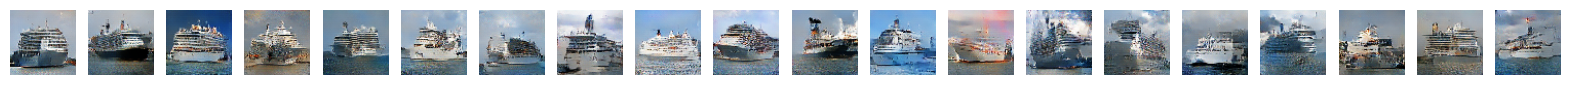

Modelo salvo após 600 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 324ms/step - d_loss: 0.1619 - g_loss: 4.4776
Epoch 601/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1631 - g_loss: 4.3234   - FID: 64.77449035644531 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 318ms/step - d_loss: 0.1631 - g_loss: 4.3236
Epoch 602/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1545 - g_loss: 4.3826   - FID: 62.19209289550781 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: 0.1546 - g_loss: 4.3829
Epoch 603/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1703 - g_loss: 4.3190   - FID: 65.13882446289062 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - d_loss: 0.1702 - g_loss: 4.3189
Epoch 604/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.1624 - g_loss: 4.4063   - FID: 63.29258346557617 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: 0.1625 - g_loss: 4.4058
Epoch 605/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1764 - g_loss: 4.2557   - FID: 

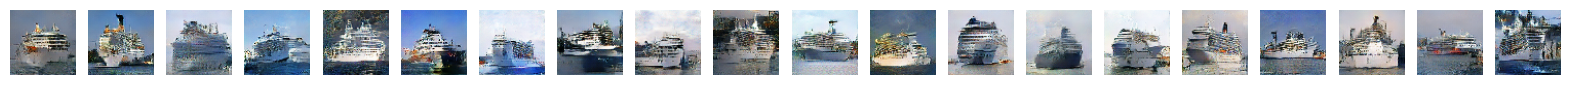

Modelo salvo após 700 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - d_loss: 0.1176 - g_loss: 5.4407
Epoch 701/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1359 - g_loss: 5.2474   - FID: 62.001739501953125 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 311ms/step - d_loss: 0.1359 - g_loss: 5.2470
Epoch 702/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1326 - g_loss: 5.0567   - FID: 63.43427276611328 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.1325 - g_loss: 5.0573
Epoch 703/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1318 - g_loss: 5.3027   - FID: 64.53115844726562 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.1318 - g_loss: 5.3026
Epoch 704/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.1313 - g_loss: 5.2383   - FID: 65.11851501464844 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.1313 - g_loss: 5.2383
Epoch 705/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1163 - g_loss: 5.2795   - FID:

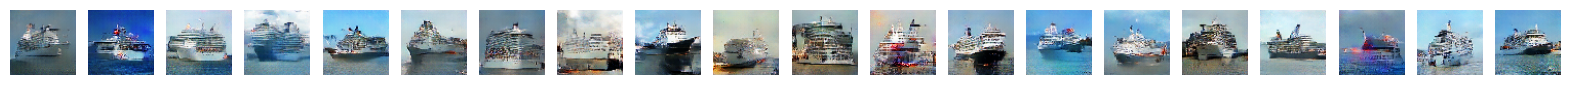

Modelo salvo após 800 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: 0.1047 - g_loss: 6.2676
Epoch 801/1500
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0946 - g_loss: 6.3693   - FID: 64.07946014404297 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.0946 - g_loss: 6.3702
Epoch 802/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0991 - g_loss: 6.2899   - FID: 63.201568603515625 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.0991 - g_loss: 6.2903
Epoch 803/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1117 - g_loss: 6.4300   - FID: 62.08736038208008 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - d_loss: 0.1117 - g_loss: 6.4294
Epoch 804/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0875 - g_loss: 6.2489   - FID: 63.152095794677734 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.0875 - g_loss: 6.2491
Epoch 805/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0903 - g_loss: 6.3873   - FID

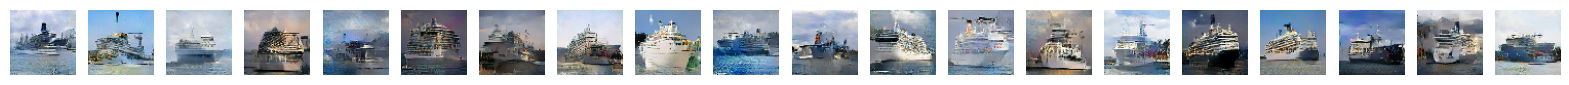

Modelo salvo após 900 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: 0.0559 - g_loss: 7.9299
Epoch 901/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.0633 - g_loss: 7.7947   - FID: 60.974891662597656 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.0633 - g_loss: 7.7944
Epoch 902/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0896 - g_loss: 7.6669   - FID: 65.49378967285156 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.0895 - g_loss: 7.6672
Epoch 903/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0598 - g_loss: 7.8301   - FID: 62.0937385559082 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.0597 - g_loss: 7.8303
Epoch 904/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0882 - g_loss: 7.7360   - FID: 62.4875602722168 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 311ms/step - d_loss: 0.0882 - g_loss: 7.7353
Epoch 905/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.0545 - g_loss: 8.1281   - FID: 6

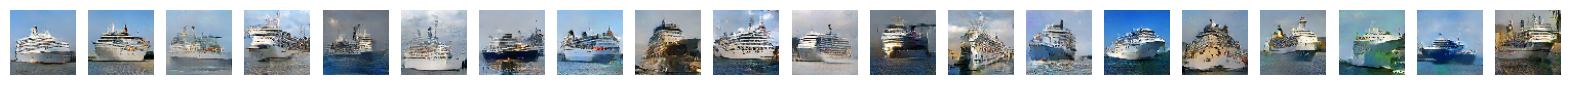

Modelo salvo após 1000 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.0524 - g_loss: 9.3017
Epoch 1001/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0525 - g_loss: 9.2259   - FID: 60.397491455078125 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - d_loss: 0.0525 - g_loss: 9.2264
Epoch 1002/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0611 - g_loss: 9.3792   - FID: 63.0164794921875 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.0611 - g_loss: 9.3784
Epoch 1003/1500
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0312 - g_loss: 9.4697   - FID: 60.98661422729492 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.0313 - g_loss: 9.4678
Epoch 1004/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.0594 - g_loss: 9.5246   - FID: 63.8734245300293 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: 0.0594 - g_loss: 9.5241
Epoch 1005/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0543 - g_loss: 9.3873   - 

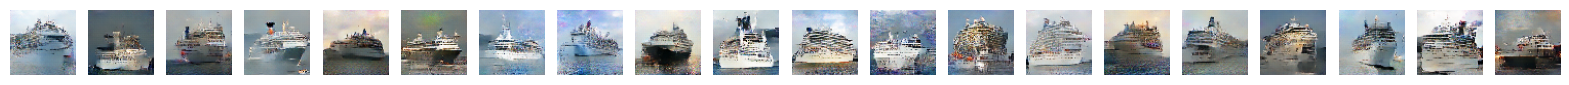

Modelo salvo após 1100 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: 0.0183 - g_loss: 11.0920
Epoch 1101/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0160 - g_loss: 11.3868   - FID: 65.05768585205078 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - d_loss: 0.0160 - g_loss: 11.3855
Epoch 1102/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0236 - g_loss: 11.8551   - FID: 62.770606994628906 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.0236 - g_loss: 11.8540
Epoch 1103/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0215 - g_loss: 11.0684   - FID: 66.54161071777344 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.0215 - g_loss: 11.0691
Epoch 1104/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.0390 - g_loss: 11.1428   - FID: 64.80857849121094 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.0390 - g_loss: 11.1436
Epoch 1105/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0687 - g_loss: 

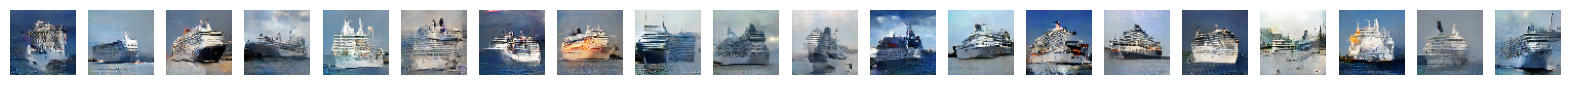

Modelo salvo após 1200 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: 0.0151 - g_loss: 13.3374
Epoch 1201/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0100 - g_loss: 13.4050   - FID: 69.29036712646484 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - d_loss: 0.0100 - g_loss: 13.4046
Epoch 1202/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0082 - g_loss: 13.2246   - FID: 63.49534225463867 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 304ms/step - d_loss: 0.0082 - g_loss: 13.2228
Epoch 1203/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.0090 - g_loss: 12.8559   - FID: 61.9624137878418 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.0090 - g_loss: 12.8566
Epoch 1204/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0094 - g_loss: 13.5401   - FID: 60.640865325927734 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: -0.0093 - g_loss: 13.5397
Epoch 1205/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0056 - g_loss

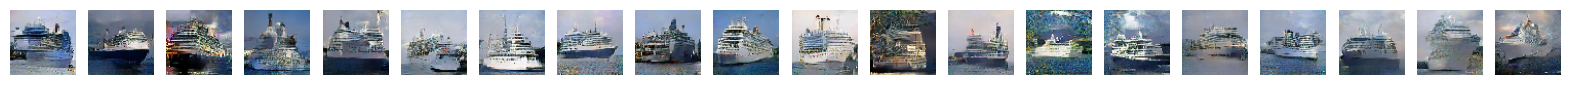

Modelo salvo após 1300 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: -0.0223 - g_loss: 15.3085
Epoch 1301/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0138 - g_loss: 15.4350   - FID: 66.3983154296875 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: -0.0137 - g_loss: 15.4329
Epoch 1302/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0128 - g_loss: 15.4671   - FID: 66.01668548583984 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: -0.0128 - g_loss: 15.4656
Epoch 1303/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: -0.0098 - g_loss: 15.1061   - FID: 65.62126922607422 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: -0.0098 - g_loss: 15.1072
Epoch 1304/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0018 - g_loss: 15.2114   - FID: 64.0428466796875 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.0018 - g_loss: 15.2112
Epoch 1305/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0146 - g_lo

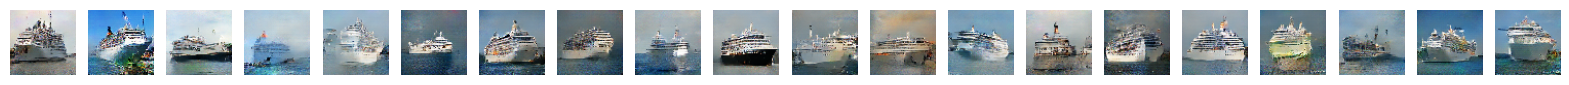

Modelo salvo após 1400 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 317ms/step - d_loss: -0.0314 - g_loss: 17.7939
Epoch 1401/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0299 - g_loss: 17.1036   - FID: 65.7444839477539 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: -0.0299 - g_loss: 17.1046
Epoch 1402/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0314 - g_loss: 17.6458   - FID: 69.26932525634766 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: -0.0314 - g_loss: 17.6454
Epoch 1403/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0370 - g_loss: 17.4548   - FID: 66.34512329101562 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: -0.0369 - g_loss: 17.4537
Epoch 1404/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0246 - g_loss: 17.7011   - FID: 67.22310638427734 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.0242 - g_loss: 17.7047
Epoch 1405/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0056 - g_

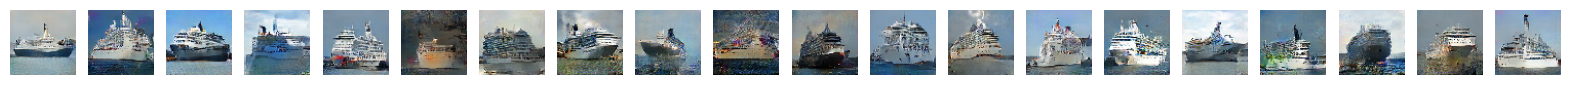

Modelo salvo após 1500 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 316ms/step - d_loss: -0.0278 - g_loss: 20.0051


In [10]:
### EXECUÇÃO ###



epochs = 1500
d_steps = 3
latent_dim = 128

save_fid = np.zeros(epochs)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, d_steps=d_steps)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=540, latent_dim=latent_dim)]
)

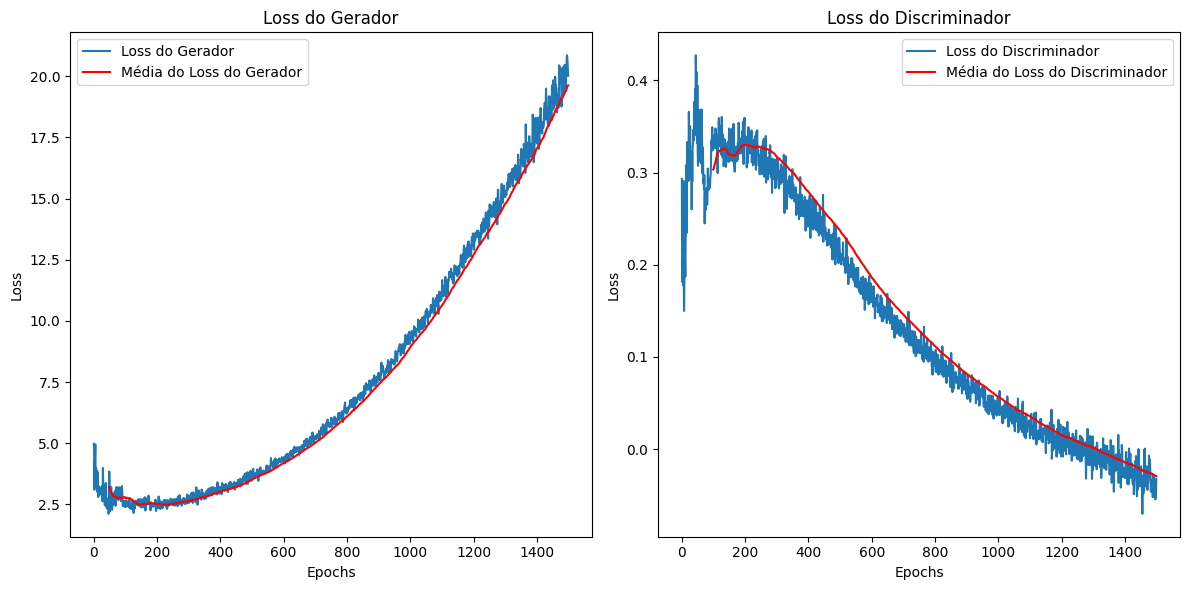

In [11]:
generator_loss = history.history['g_loss']
generator_loss_series = pd.Series(generator_loss)
generator_loss_rolling = generator_loss_series.rolling(window=50).mean()

discriminator_loss = history.history['d_loss']
discriminator_loss_series = pd.Series(discriminator_loss)
discriminator_loss_rolling = discriminator_loss_series.rolling(window=100).mean()

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(generator_loss, label='Loss do Gerador')
plt.plot(generator_loss_rolling, color='r', linestyle='-', label = 'Média do Loss do Gerador')
plt.title('Loss do Gerador')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(discriminator_loss, label='Loss do Discriminador')
plt.plot(discriminator_loss_rolling, color='r', linestyle='-', label = 'Média do Loss do Discriminador')
plt.title('Loss do Discriminador')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Menor FID:           59.299652099609375
Época da menor perda:  929


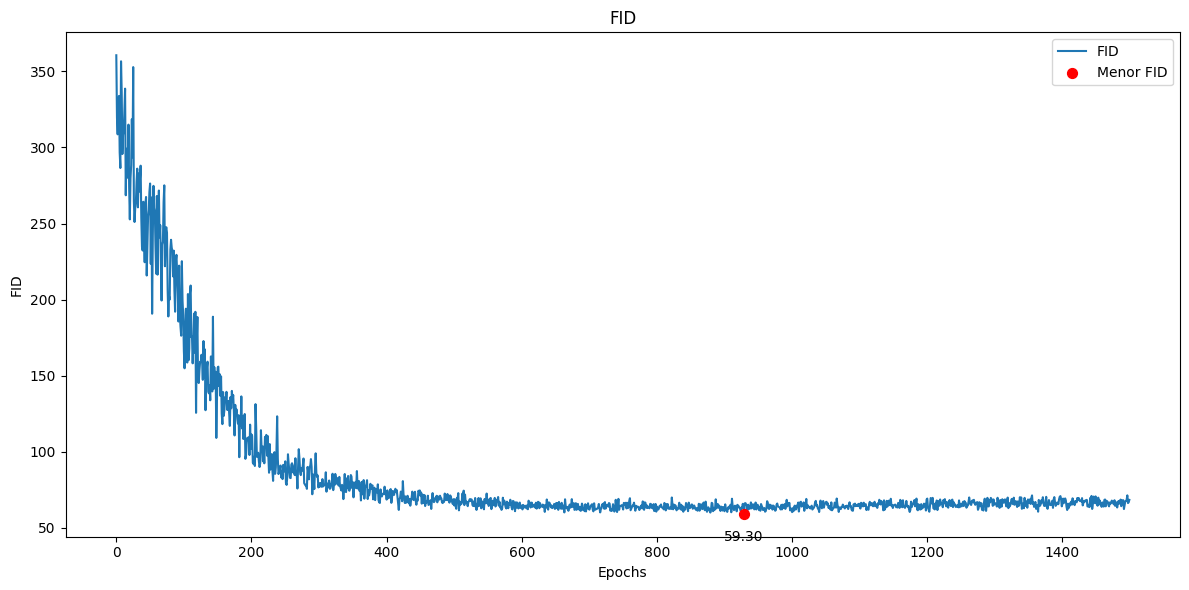

In [12]:
menor_fid = 999
for i in range(epochs):
    if save_fid[i]<menor_fid:
        menor_fid = save_fid[i]
        epoch_m = i
        
print('Menor FID:          ',menor_fid)
print('Época da menor perda: ',epoch_m)

plt.figure(figsize=(12,6))
plt.plot(save_fid, label='FID')
plt.scatter(epoch_m, menor_fid, color='r', zorder=5, label = 'Menor FID', s=50)
plt.text(epoch_m, menor_fid-20, f"{menor_fid:.2f}", ha='center', va='bottom')
plt.title('FID')
plt.xlabel('Epochs')
plt.ylabel('FID')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
generator = keras.models.load_model(best_path)
discriminator = keras.models.load_model(best_path.replace("best_dcgan_checkpoint", "best_dcgan_discriminator"))

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, d_steps=d_steps)

In [14]:
num_img = 5400
output_dir = str(fake_dir + "/" + generating_class + "/")
os.makedirs(output_dir, exist_ok=True)
filename = str(generating_class + "%d.png")
output_path = os.path.join(output_dir, filename)

latent_dim=128
seed_generator = keras.random.SeedGenerator(1337)

for i in tqdm(range(num_img),desc="Gerando imagens"):
    random_latent_vectors = keras.random.normal(
        shape=(1, latent_dim), seed=seed_generator
    )
    generated_images = gan.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    img = keras.utils.array_to_img(generated_images[0])
    img.save(output_path % (i))

Gerando imagens: 100%|██████████████████████████████████████████████████████████████| 5400/5400 [00:57<00:00, 93.57it/s]


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Processando classe 'PASSENGERSSHIP': 100%|████████████████████████████████████████████| 540/540 [08:06<00:00,  1.11it/s]



Métricas para a classe 'PASSENGERSSHIP':
  SSIM (média): 0.1578
  Inception Score (Real): 1.6887
  Inception Score (Gerado): 1.9569
  FID: 46.3539


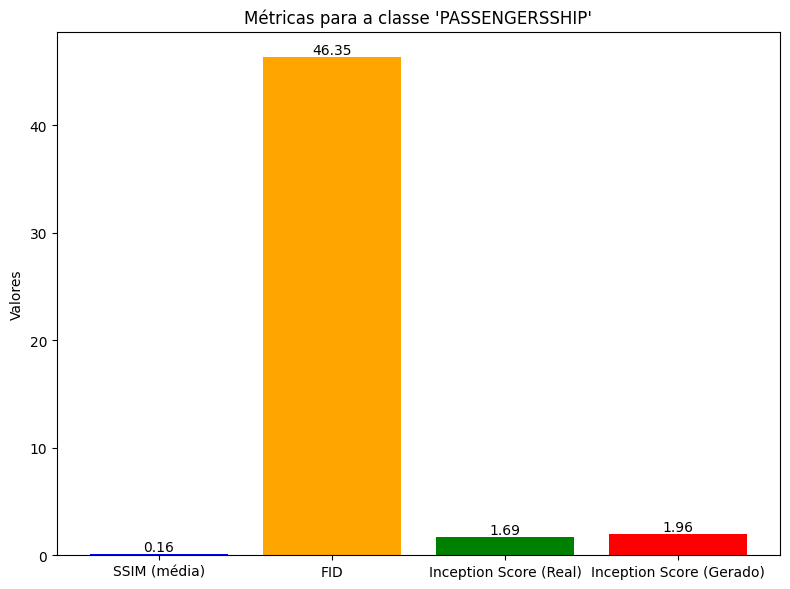

In [15]:
metrics = calculate_metrics(real_dir, fake_dir, generating_class, num_samples=num_img)
print_metrics(metrics, generating_class)
plot_metrics_for_class(metrics, generating_class)

In [16]:
# Caminhos para as imagens de entrada e saída
input_dir = str(fake_dir + '/' + generating_class)   # Substitua pelo diretório das imagens de entrada
output_dir = str(fake_dirx4 + '/' + generating_class)  # Substitua pelo diretório das imagens de saída

# Certifique-se de que o diretório de saída existe
os.makedirs(output_dir, exist_ok=True)

process_images(input_dir, output_dir)
print("Processamento concluído!")

Aumentando imagens: 100%|███████████████████████████████████████████████████████████| 5400/5400 [04:54<00:00, 18.33it/s]

Processamento concluído!


Processando classe 'PASSENGERSSHIP': 100%|████████████████████████████████████████████| 540/540 [08:13<00:00,  1.09it/s]



Métricas para a classe 'PASSENGERSSHIP':
  SSIM (média): 0.1900
  Inception Score (Real): 1.6882
  Inception Score (Gerado): 2.0238
  FID: 26.8937


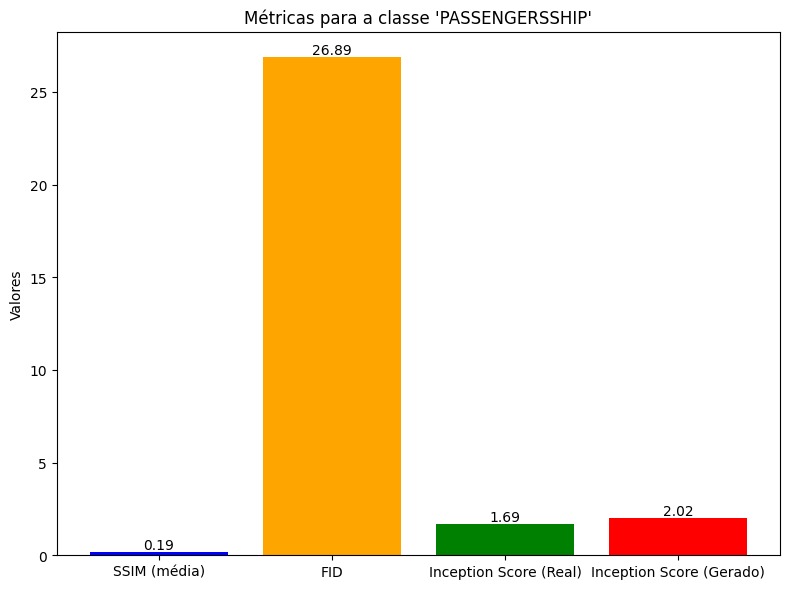

In [17]:
metrics = calculate_metrics(real_dir, fake_dirx4, generating_class, num_samples=num_img)
print_metrics(metrics, generating_class)
plot_metrics_for_class(metrics, generating_class)